# 读取库文件

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as smpip
import numpy as np
import statsmodels
plt.style.use('classic')#设置样式表风格
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import warnings
# 忽略运行时警告信息
warnings.filterwarnings('ignore')
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error #MAE

In [35]:
data = pd.read_excel('data.xlsx')
print(data.head())

        YMD         mean
0  20090101  2573.974370
1  20090102  3479.023373
2  20090103  4026.499732
3  20090104  4076.881717
4  20090105  4548.918550


# 预测的目标列转化为时间序列格式

In [36]:
y1 = data['mean'].astype(float).squeeze()
ts = pd.Series(y1)

# 划分训练集、测试集、预测集

In [37]:
#前80%作为训练集，后20%作为测试集，未来20个作为预测集
train = ts[:int(len(ts)*0.8)]
test = ts[int(len(ts)*0.8):]
step = 20#往后预测20个
print("train:",len(train))
print("test:",len(test))

train: 1760
test: 441


# 原始数据序列图

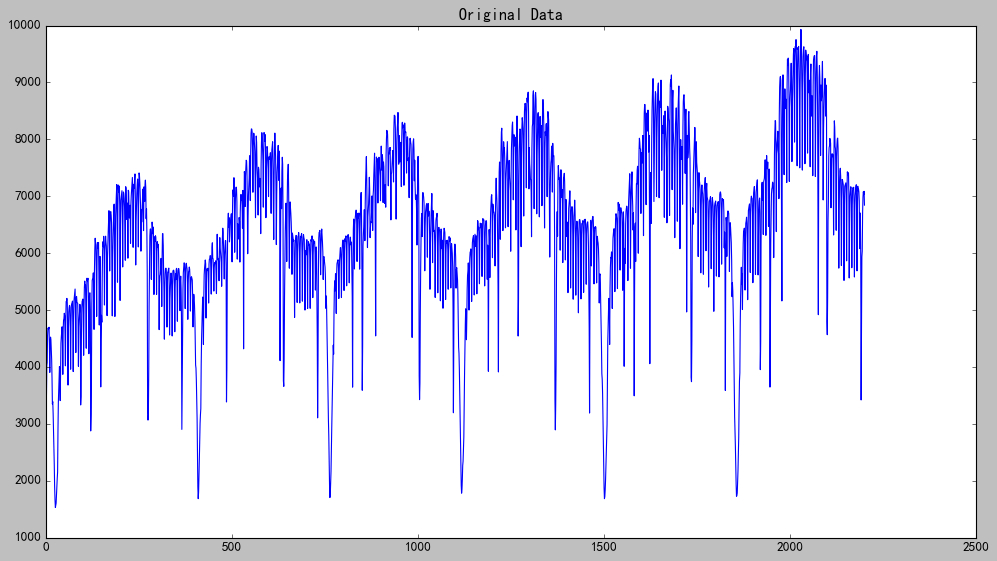

In [38]:
# 绘制原始数据图表
plt.figure(figsize=(15, 8))
plt.plot(ts)
plt.title('Original Data')
plt.show()

观察季节性和趋势性

# 计算统计量

In [39]:
# 计算均值、标准差、最大值和最小值
mean = np.mean(ts)
std = np.std(ts)
max_value = np.max(ts)
min_value = np.min(ts)

# 输出结果
print("均值:", mean)
print("标准差:", std)
print("最大值:", max_value)
print("最小值:", min_value)

均值: 6488.576545154929
标准差: 1458.494277349117
最大值: 9932.192387000005
最小值: 1528.4930249999998


# 提取序列的趋势、季节和随机效应（残差）

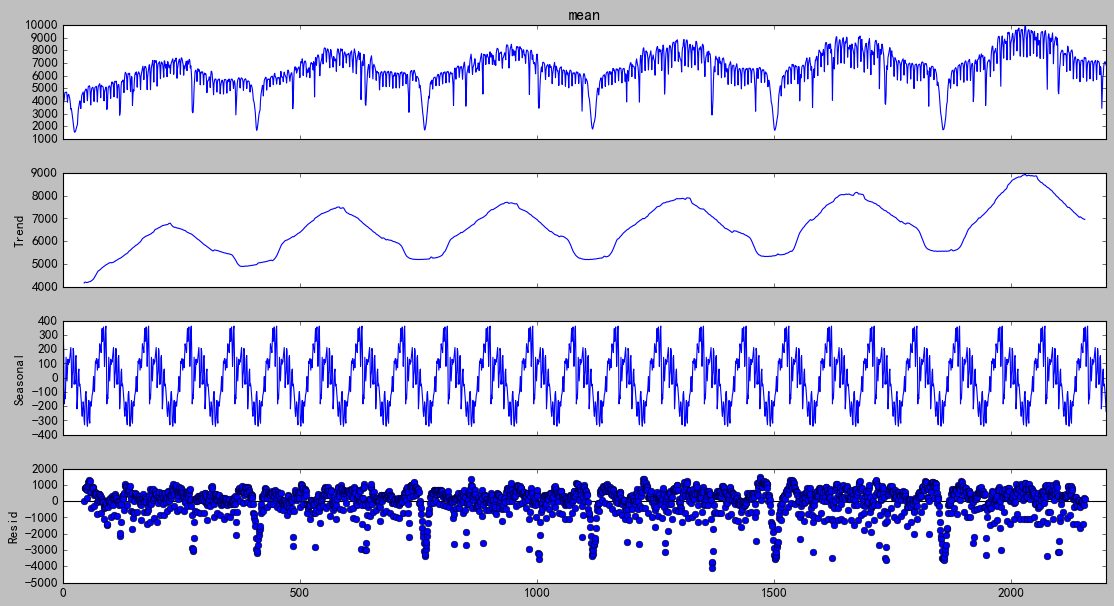

In [40]:
#分解成趋势（trend）季节性（seasonality）和残差（residual）****************************
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts,period=90,model="add")
fig = res.plot()
# 调整图的大小
fig = plt.gcf()
fig.set_size_inches(15, 8)

# 自相关ACF，偏自相关PACF图像

In [41]:
def draw_acf_pacf(ts,lags=24):
    f = plt.figure()
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags,color = 'royalblue')
    plt.title("自相关性",fontdict={'weight':'normal','size': 15})
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags,color = 'royalblue')
    plt.title("偏自相关性", fontdict={'weight': 'normal', 'size': 15})
    # 调整图的大小
    fig = plt.gcf()
    fig.set_size_inches(15, 8)
    #plt.subplots_adjust(hspace=0.5)
    plt.show()

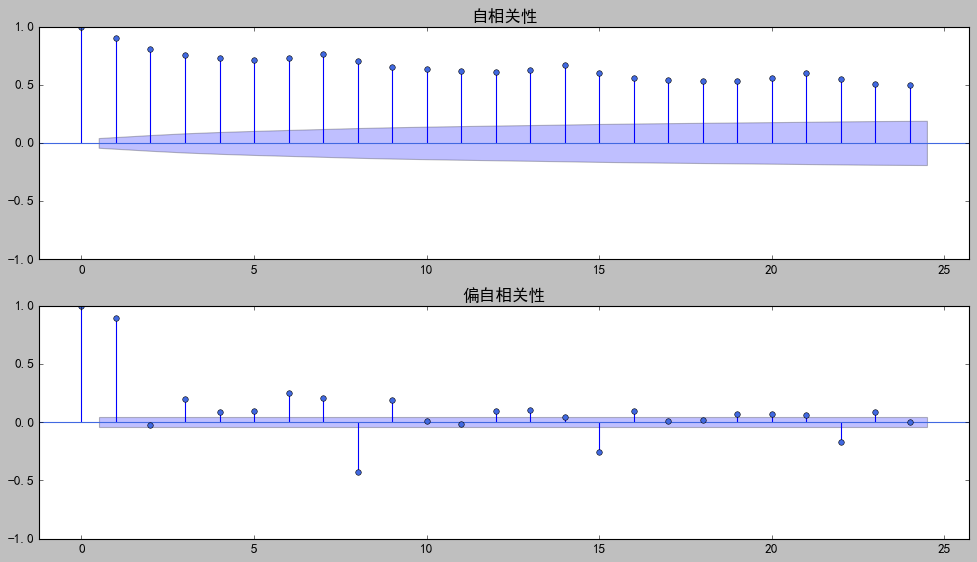

In [42]:
draw_acf_pacf(ts,lags=24)

ACF拖尾（指数衰减），PACF拖尾（震荡）

# 白噪声检验

ARIMA的数据必须是平稳非白噪声序列

In [43]:
from statsmodels.stats.diagnostic import acorr_ljungbox

#白噪声检验
def test_stochastic(ts, lags=24, alpha=0.05):#返回统计量和p值  lags为检验的延迟数
    p_value = acorr_ljungbox(ts, lags=lags) #lags可自定义
    print(p_value)
    if np.min(p_value['lb_pvalue']) < alpha:
        return '该序列不是白噪声序列'
    else:
        return '该序列是白噪声序列'
    return p_value
    #返回统计量和p值,lb_pvalue>0.05则为白噪声序列

In [44]:
print(test_stochastic(ts,lags=3))

       lb_stat  lb_pvalue
1  1781.329068        0.0
2  3204.115383        0.0
3  4465.791191        0.0
该序列不是白噪声序列


# ADF平稳性检验

In [45]:
# Dickey-Fuller test（ADF平稳性检验）:
# 原假设：序列中存在单位根（非平稳数据）
# Dickey-Fuller test（ADF平稳性检验）:
def teststationarity(ts, max_lag=None):
    dftest = statsmodels.tsa.stattools.adfuller(ts, maxlag=max_lag)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    # 添加临界值到输出结果
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    # 判断平稳性：检验统计量是否小于1%显著性水平的临界值
    if(dfoutput['Test Statistic'] < dfoutput['Critical Value (1%)']):
        print("ADF平稳性检验:")
        print("****** Test Statistic < Critical Value (1%) ******\n             此序列为平稳序列")
    return dfoutput
# Number of Observations Used（有效观测数：总样本数-滞后阶数-1）表示实际用于计算的有效数据量
# 计算检验统计量的值和临界值(1%、5%)相比，判断接受/拒绝原假设
# 也可以使用p值和显著性水平（0.05）相比

In [46]:
print(teststationarity(ts))# 平稳性检验

ADF平稳性检验:
****** Test Statistic < Critical Value (1%) ******
             此序列为平稳序列
Test Statistic                   -4.004688
p-value                           0.001386
#Lags Used                       26.000000
Number of Observations Used    2174.000000
Critical Value (1%)              -3.433362
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


检验统计量小于1%的临界值，p值也小于0.01（1%显著性水平）在1%显著性水平下拒绝原假设，序列平稳

# ADF单位根检验哪阶差分之后数据平稳

In [47]:
# 进行差分处理
diff1 = ts.diff().dropna()#一阶差分
diff2 = diff1.diff().dropna()#二阶差分
diff3 = diff2.diff().dropna()#三阶差分

In [48]:
print(teststationarity(diff1))# 平稳性检验

ADF平稳性检验:
****** Test Statistic < Critical Value (1%) ******
             此序列为平稳序列
Test Statistic                -1.390987e+01
p-value                        5.535625e-26
#Lags Used                     2.500000e+01
Number of Observations Used    2.174000e+03
Critical Value (1%)           -3.433362e+00
Critical Value (5%)           -2.862870e+00
Critical Value (10%)          -2.567478e+00
dtype: float64


In [49]:
print(teststationarity(ts))# 平稳性检验

ADF平稳性检验:
****** Test Statistic < Critical Value (1%) ******
             此序列为平稳序列
Test Statistic                   -4.004688
p-value                           0.001386
#Lags Used                       26.000000
Number of Observations Used    2174.000000
Critical Value (1%)              -3.433362
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


# 差分后平稳的数据序列图

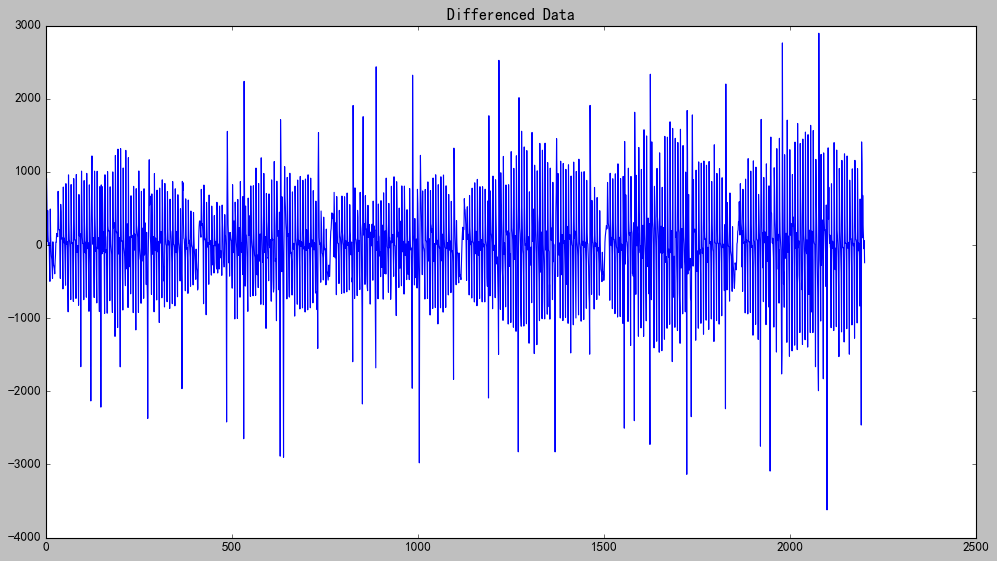

In [54]:
# 绘制差分后平稳的数据图表
plt.figure(figsize=(15,8))
plt.plot(diff1)
plt.title('Differenced Data')
plt.show()
#差分阶数d
d = 0

# 绘制差分后的ACF和PACF图像

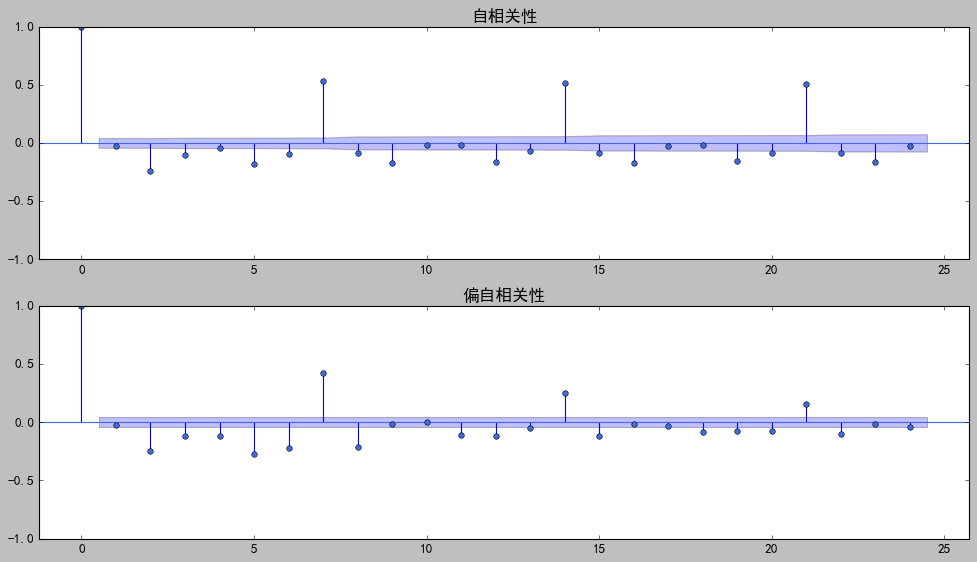

In [55]:
draw_acf_pacf(diff1,lags=24)

找到最大参数次数：p=1，q=1

# 使用AIC和BIC信息准则：寻找最优参数组合的ARIMA模型

In [56]:
#通过遍历所有可能的 (p, q) 参数组合，找到使 AIC（赤池信息准则） 和 BIC（贝叶斯信息准则） 最小的 ARIMA 模型，从而确定最优的 (p, d, q) 阶数
p_min, p_max = 0, 3
q_min, q_max = 0, 3
best_aic = np.inf
best_bic = np.inf
best_order = None
for p in range(p_min, p_max+1):
    for q in range(q_min, q_max+1):
                try:
                    # 创建 ARIMA 模型并拟合
                    model = sm.tsa.arima.ARIMA(ts, order=(p, d, q))
                    result = model.fit()
                    # 更新最优模型
                    if result.aic < best_aic and result.bic < best_bic:
                        best_aic = result.aic
                        best_bic = result.bic
                        best_order = (p, d, q)
                except:
                    continue

print("Best AIC: ", best_aic)
print("Best BIC: ", best_bic)
print("Best order: ", best_order)

Best AIC:  34225.711648792625
Best BIC:  34265.58831836331
Best order:  (3, 0, 2)


# 模型检验

## 残差是检验模型是否成功捕捉所有信息的有效指标，若残差是白噪声，则模型比较好

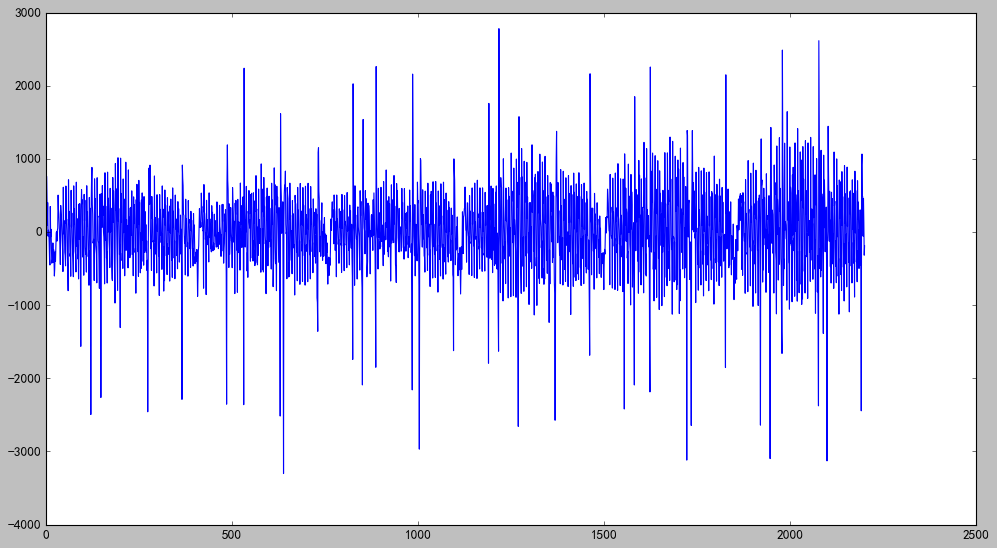

In [20]:
# 绘制残差序列图初步检查随机性
resid=result.resid  #残差
plt.figure(figsize=(15,8))
plt.plot(resid)

理想状态
残差无规律波动，无明显模式。
如果：
1.呈现残差随时间递增/递减 → 模型未捕捉长期趋势。
——————增加差分阶数d，消除趋势
2.残差呈现规律波动 → 模型未提取季节性。
——————增加季节性参数，改用SARIMA
3.残差波动幅度随时间变化 → 方差非恒定。
——————进行数据变换，稳定方差？？？？我不太懂这个

#  残差白噪声检验，若残差序列不是白噪声，则其中还含有部分有用信息

In [21]:
#  残差白噪声检验，若残差序列不是白噪声，则其中还含有有用信息
print(test_stochastic(resid,5))

      lb_stat     lb_pvalue
1    0.000906  9.759904e-01
2    0.605507  7.387812e-01
3  186.259672  3.922282e-40
4  317.569462  1.754700e-67
5  322.066266  1.798766e-67
该序列是白噪声序列


若残差不是白噪声，则模型未充分提前信息，需要调整p、q阶数或差分d

# 残差正态性检验，ARIMA模型假设残差服从正态分布，进一步验证假设

In [22]:
from scipy import stats
x = stats.normaltest(resid)#检验序列残差是否为正态分布    pvalue<  0.05  拒绝原假设 认为残差符合正态分布

In [23]:
if x.pvalue < 0.05:
    print('pvalue = {} < 0.05, 故残差符合正态分布'.format(x.pvalue))

pvalue = 1.3798837247629905e-90 < 0.05, 故残差符合正态分布


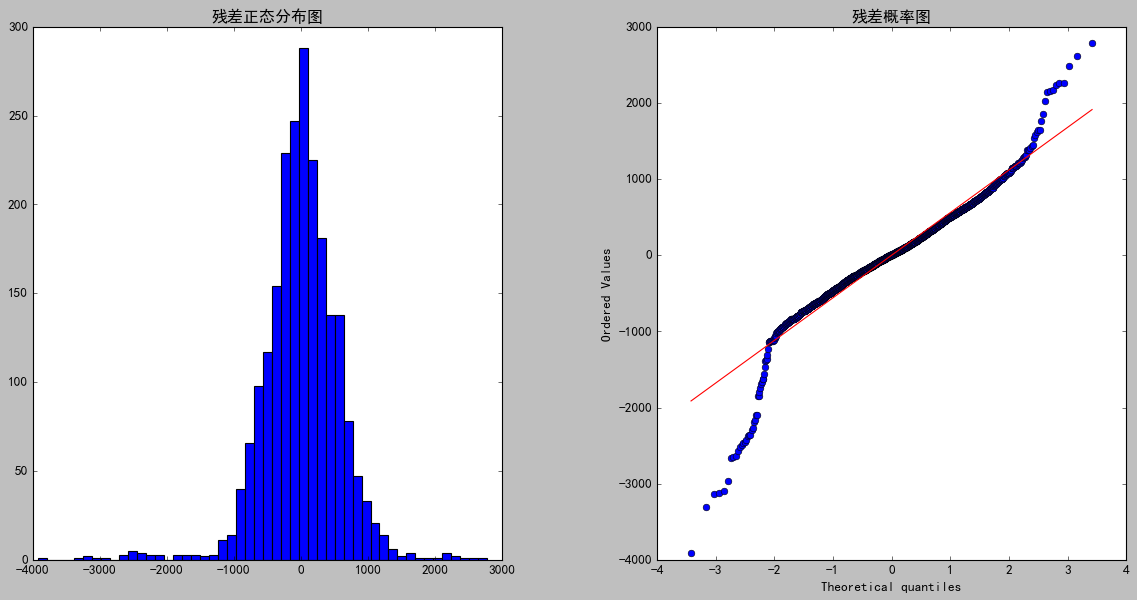

In [24]:
# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2)

# 绘制第一个子图
ax1.hist(resid,bins=50)
ax1.set_title("残差正态分布图")

# 绘制第二个子图
stats.probplot(resid, dist="norm", plot=plt)
ax2.set_title("残差概率图")

# 调整子图之间的间距
plt.tight_layout()

# 调整图形大小
fig.set_size_inches(15, 8)

# 显示图形
plt.show()

# DW残差序列自相关检验 ，白噪声之间不存在自相关关系

In [25]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(result.resid.values)     ##DW检验：靠近2——正常；靠近0——正自相关；靠近4——负自相关

In [26]:
dw #dw更加接近2，表明残差独立不存在自相关性

np.float64(1.9778565358068458)

理想状态：DW值接近2。
如果：
DW显著偏离2 → 残差存在一阶自相关。
调整方法
增加 q 阶数：添加移动平均项消除自相关。
增加 p 阶数：通过自回归项修正残差依赖。

# 以最优参数建立ARIMA模型

In [27]:
model = sm.tsa.arima.ARIMA(endog=train, order=best_order)
# 输出模型的摘要信息
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   mean   No. Observations:                 1760
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -13595.850
Date:                Wed, 23 Apr 2025   AIC                          27205.700
Time:                        14:07:52   BIC                          27244.012
Sample:                             0   HQIC                         27219.859
                               - 1760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6320.1755    994.544      6.355      0.000    4370.906    8269.445
ar.L1          0.5389      0.012     45.945      0.000       0.516       0.562
ar.L2         -0.5581      0.006    -99.189      0.0

# 预测

In [28]:
predtrain = results.predict(start=1,end=len(train))
predtrain = np.array(predtrain)

In [29]:
#对测试集数据进行预测验证
inputdata = train
predtest = []
for i in range(0,(len(test))):
    history = inputdata
    model = sm.tsa.arima.ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(1)
    predtest.append(float(yhat))
    inputdata = np.append(inputdata, [test.iloc[i]])
predtest = np.array(predtest)

In [30]:
#预测未来
inputdata = ts
pred = []
for i in range(0,step):
    history = inputdata
    model = sm.tsa.arima.ARIMA(history, order=best_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(1)
    pred.append(float(yhat))
    inputdata = np.append(inputdata, [yhat])
pred = np.array(pred)

In [31]:
x = np.concatenate((predtrain, predtest, pred))
y = np.concatenate((predtrain, predtest))
z = predtrain

In [32]:
# 计算置信区间（使用标准差方法）
forecast_error1 = results.resid
forecast_std1 = np.std(forecast_error1)
z_score = 1.96  # 95% 置信区间对应的Z值

In [33]:
t = np.concatenate((predtest, pred))
forecast_lower = t - z_score * forecast_std1
forecast_upper = t + z_score * forecast_std1

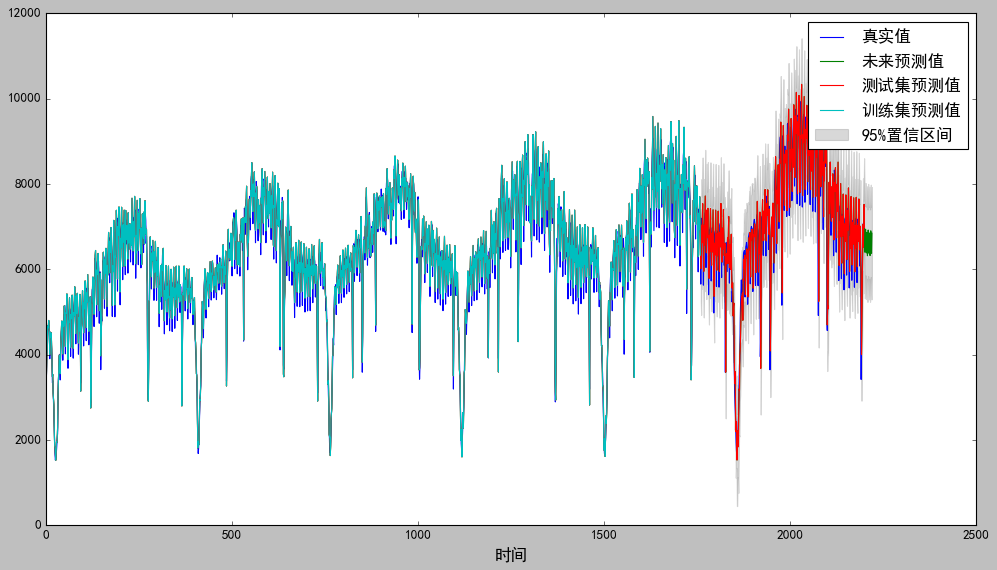

In [34]:
plt.figure(figsize=(15, 8))
plt.xlabel('时间',fontsize=15)
plt.plot(ts,label='真实值')
plt.plot(x,label='未来预测值')
plt.plot(y,label='测试集预测值',linestyle = '-')
plt.plot(z,label='训练集预测值',linestyle = '-')
plt.fill_between(np.arange(len(z),len(x)), forecast_lower, forecast_upper, color='gray', alpha=0.3, label='95%置信区间')
plt.legend(fontsize=15)

In [35]:
# 将数组转换为 DataFrame
df = pd.DataFrame(pred)
df.columns = ['未来预测值']
# 将 DataFrame 写入 CSV 文件
file_name = 'output.csv'
df.to_csv(file_name, index=False)

# 模型评估

In [36]:
def metrics_sklearn(y_valid, y_pred_,model='model'):
    r2 = r2_score(y_valid, y_pred_)  # R^2评价
    print(model + '_R2：{}'.format(r2))
    
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred_))  # rmse评价
    print(model + '_rmse：{}'.format(rmse))
    
    mae = mean_absolute_error(y_valid, y_pred_)  # mae评价
    print(model + '_mae：{}'.format(mae))
    
    mse = mean_squared_error(y_valid, y_pred_)  # mae评价
    print(model + '_mse：{}'.format(mse))
    
    assess = pd.DataFrame([[r2,rmse,mae,mse]],columns=['R2','rmse','mae','mse'],index = [model])
    return assess

In [37]:
w = metrics_sklearn(test,predtest)

model_R2：0.8046614294452792
model_rmse：673.1383245948533
model_mae：497.83520349718515
model_mse：453115.20403836615


拟合优度R2:越大表明模型能够解释目标变量约80.5%的方差，说明模型对数据的拟合效果较好
MAE（497.84）：平均绝对误差为497.84，表示预测值与真实值的平均偏离程度
RMSE（673.14）与MSE（453,115.20）：RMSE是MSE的平方根，其值大于MAE（673 > 497），表明模型存在部分预测误差较大的情况（如异常值或极端值的影响）。需进一步检查数据分布或残差模式，判断是否需要处理异常值或优化模型。

优势：较高的R²值表明模型整体拟合良好，适用于解释变量与目标变量之间的关系。

潜在问题：RMSE与MAE的差异（约175）提示模型对某些样本的预测误差较大，可能受极端值或非线性关系影响。
建议：
检查数据分布：确认目标变量是否存在长尾或离群点，必要时进行数据清洗或变换（如对数变换）。
残差分析：绘制残差图，验证误差是否随机分布。若存在模式（如残差随预测值增大而增大），可能需要引入非线性特征或更复杂的模型。
模型优化：尝试集成模型（如随机森林、梯度提升树）或正则化方法（如Lasso/Ridge），以提升鲁棒性。